# Beijing Air Quality Forecasting

# Load and Preprocess Data
This section is responsible for loading the air quality dataset and preprocessing it for model training. It includes functions to load data, handle missing values, and prepare features and targets for training.

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Create submissions directory
os.makedirs('submissions', exist_ok=True)

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Preprocessing function
def preprocess_data(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

# Process both datasets
train = preprocess_data(train)
test = preprocess_data(test)

# Handle missing values
train.fillna(train.mean(numeric_only=True), inplace=True)
test.fillna(test.mean(numeric_only=True), inplace=True)

# Prepare features and target
features = [col for col in train.columns if col not in ['pm2.5', 'No']]
target = 'pm2.5'

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(train[features])
X_test = scaler.transform(test[features])
y_train = train[target].values

# Sequence generator
def create_sequences(data, targets, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(targets[i])
    return np.array(X), np.array(y)

# Experiment configurations

In [20]:
# Experiment configuration

experiments = [
    # Experiment 1-20 configurations
    {'exp_num': 1, 'units': 32, 'dropout': 0.2, 'batch_size': 32, 'lr': 0.001, 'epochs': 30, 'seq_len': 24},
    {'exp_num': 2, 'units': 64, 'dropout': 0.2, 'batch_size': 32, 'lr': 0.001, 'epochs': 30, 'seq_len': 24},
    {'exp_num': 3, 'units': 128, 'dropout': 0.3, 'batch_size': 32, 'lr': 0.001, 'epochs': 30, 'seq_len': 24},
    {'exp_num': 4, 'units': 32, 'dropout': 0.4, 'batch_size': 64, 'lr': 0.001, 'epochs': 30, 'seq_len': 24},
    {'exp_num': 5, 'units': 64, 'dropout': 0.4, 'batch_size': 64, 'lr': 0.001, 'epochs': 30, 'seq_len': 24},
    {'exp_num': 6, 'units': 128, 'dropout': 0.5, 'batch_size': 64, 'lr': 0.001, 'epochs': 30, 'seq_len': 24},
    {'exp_num': 7, 'units': 32, 'dropout': 0.2, 'batch_size': 32, 'lr': 0.01, 'epochs': 30, 'seq_len': 48},
    {'exp_num': 8, 'units': 64, 'dropout': 0.2, 'batch_size': 32, 'lr': 0.01, 'epochs': 30, 'seq_len': 48},
    {'exp_num': 9, 'units': 128, 'dropout': 0.3, 'batch_size': 32, 'lr': 0.01, 'epochs': 30, 'seq_len': 48},
    {'exp_num': 10, 'units': 32, 'dropout': 0.4, 'batch_size': 64, 'lr': 0.01, 'epochs': 35, 'seq_len': 48},
    {'exp_num': 11, 'units': 64, 'dropout': 0.4, 'batch_size': 64, 'lr': 0.01, 'epochs': 35, 'seq_len': 48},
    {'exp_num': 12, 'units': 128, 'dropout': 0.5, 'batch_size': 64, 'lr': 0.01, 'epochs': 35, 'seq_len': 48},
    {'exp_num': 13, 'units': 32, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'epochs': 35, 'seq_len': 72},
    {'exp_num': 14, 'units': 64, 'dropout': 0.2, 'batch_size': 128, 'lr': 0.001, 'epochs': 35, 'seq_len': 72},
    {'exp_num': 15, 'units': 128, 'dropout': 0.3, 'batch_size': 128, 'lr': 0.001, 'epochs': 35, 'seq_len': 72},
    {'exp_num': 16, 'units': 32, 'dropout': 0.4, 'batch_size': 128, 'lr': 0.01, 'epochs': 40, 'seq_len': 72},
    {'exp_num': 17, 'units': 64, 'dropout': 0.4, 'batch_size': 128, 'lr': 0.01, 'epochs': 40, 'seq_len': 72},
    {'exp_num': 18, 'units': 128, 'dropout': 0.5, 'batch_size': 128, 'lr': 0.01, 'epochs': 40, 'seq_len': 72},
    {'exp_num': 19, 'units': 64, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.005, 'epochs': 50, 'seq_len': 24},
    {'exp_num': 20, 'units': 128, 'dropout': 0.3, 'batch_size': 64, 'lr': 0.005, 'epochs': 50, 'seq_len': 48}
]

# Track Experiments and Results
This section manages the execution of multiple experiments with different model configurations. It stores results, including RMSE and model parameters, for comparison and analysis.

In [21]:
# Experiment tracking
results = []
best_submissions = []

for exp in experiments:
    try:
        print(f"\nRunning Experiment {exp['exp_num']}")
        
        # Create sequences
        X_seq, y_seq = create_sequences(X_train, y_train, exp['seq_len'])
        
        # Train/validation split
        split = int(0.8 * len(X_seq))
        X_train_seq, X_val = X_seq[:split], X_seq[split:]
        y_train_seq, y_val = y_seq[:split], y_seq[split:]
        
        # Build model
        model = Sequential([
            LSTM(exp['units'], input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
            Dropout(exp['dropout']),
            Dense(1)
        ])
        
        model.compile(
            optimizer=Adam(learning_rate=exp['lr']),
            loss='mse',
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        
        # Train model
        history = model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_val, y_val),
            epochs=exp['epochs'],
            batch_size=exp['batch_size'],
            verbose=0
        )
        
        # Evaluate
        val_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        
        # Store results
        results.append({
            'Experiment': exp['exp_num'],
            'Parameters': f"units={exp['units']}, lr={exp['lr']}, seq={exp['seq_len']}",
            'Architecture': f"LSTM({exp['units']})",
            'RMSE': rmse,
            'Epochs': exp['epochs']
        })
        
        # Generate test predictions
        X_test_seq, _ = create_sequences(np.vstack([X_train[-exp['seq_len']:], X_test]), 
                                       np.zeros(len(X_test)+exp['seq_len']), 
                                       exp['seq_len'])
        test_pred = model.predict(X_test_seq)[-len(test):]
        
        # Create submission file
        submission = pd.DataFrame({
            'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %H:%M:%S').str.replace(r'(?<=\s)0(\d):', r'\1:', regex=True),  # Remove leading zeros for hours
            ;'pm2.5': test_pred.flatten()
        }).sort_values('row ID')
        
        # Save submission
        submission_path = f'submissions/exp_{exp["exp_num"]}_submission.csv'
        submission.to_csv(submission_path, index=False)
        print(f"Saved submission to {submission_path}")
        
        # Track best submissions
        best_submissions.append((rmse, exp['exp_num'], submission_path))
        best_submissions.sort(key=lambda x: x[0])
        if len(best_submissions) > 2:
            best_submissions.pop()
            
    except Exception as e:
        print(f"Experiment {exp['exp_num']} failed: {str(e)}")
        continue


Running Experiment 1


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Saved submission to submissions/exp_1_submission.csv

Running Experiment 2


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Saved submission to submissions/exp_2_submission.csv

Running Experiment 3


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Saved submission to submissions/exp_3_submission.csv

Running Experiment 4


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Saved submission to submissions/exp_4_submission.csv

Running Experiment 5


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Saved submission to submissions/exp_5_submission.csv

Running Experiment 6


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Saved submission to submissions/exp_6_submission.csv

Running Experiment 7


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Saved submission to submissions/exp_7_submission.csv

Running Experiment 8


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Saved submission to submissions/exp_8_submission.csv

Running Experiment 9


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Saved submission to submissions/exp_9_submission.csv

Running Experiment 10


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Saved submission to submissions/exp_10_submission.csv

Running Experiment 11


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Saved submission to submissions/exp_11_submission.csv

Running Experiment 12


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Saved submission to submissions/exp_12_submission.csv

Running Experiment 13


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Saved submission to submissions/exp_13_submission.csv

Running Experiment 14


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Saved submission to submissions/exp_14_submission.csv

Running Experiment 15


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step
Saved submission to submissions/exp_15_submission.csv

Running Experiment 16


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Saved submission to submissions/exp_16_submission.csv

Running Experiment 17


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Saved submission to submissions/exp_17_submission.csv

Running Experiment 18


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step
Saved submission to submissions/exp_18_submission.csv

Running Experiment 19


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Saved submission to submissions/exp_19_submission.csv

Running Experiment 20


C:\Users\MaximeGuy\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Saved submission to submissions/exp_20_submission.csv


# Evaluate and Save Model Submissions
This section evaluates the best-performing models and saves the submissions to CSV files. It also generates a report of the best submissions.

In [23]:
# Save best submissions
print("\nTop 2 Submissions:")
for i, (rmse, exp_id, path) in enumerate(best_submissions[:2], 1):
    best_sub = pd.read_csv(path)
    best_path = f'submissions/best_submission_{i}.csv'
    best_sub.to_csv(best_path, index=False)
    print(f"Best {i}: Experiment {exp_id} (RMSE: {rmse:.2f})")

# Generate experiment report
results_df = pd.DataFrame(results)
print("\nExperiment Results:")
print(results_df[['Experiment', 'Parameters', 'Architecture', 'RMSE']].to_markdown(index=False))


Top 2 Submissions:
Best 1: Experiment 17 (RMSE: 72.38)
Best 2: Experiment 9 (RMSE: 73.75)

Experiment Results:
|   Experiment | Parameters                  | Architecture   |     RMSE |
|-------------:|:----------------------------|:---------------|---------:|
|            1 | units=32, lr=0.001, seq=24  | LSTM(32)       |  86.0382 |
|            2 | units=64, lr=0.001, seq=24  | LSTM(64)       |  80.7808 |
|            3 | units=128, lr=0.001, seq=24 | LSTM(128)      |  84.8619 |
|            4 | units=32, lr=0.001, seq=24  | LSTM(32)       |  82.3013 |
|            5 | units=64, lr=0.001, seq=24  | LSTM(64)       |  81.6501 |
|            6 | units=128, lr=0.001, seq=24 | LSTM(128)      |  84.3119 |
|            7 | units=32, lr=0.01, seq=48   | LSTM(32)       |  77.9684 |
|            8 | units=64, lr=0.01, seq=48   | LSTM(64)       |  77.9215 |
|            9 | units=128, lr=0.01, seq=48  | LSTM(128)      |  73.7476 |
|           10 | units=32, lr=0.01, seq=48   | LSTM(32)       |

# Generate Training Loss Plots for Best Models
This section visualizes the training loss for the top-performing models. It plots the training loss over epochs and saves the resulting figures for documentation.


Generating Training Loss Plots for Best Models...
766/766 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step
Train Loss: 846.6376496889275


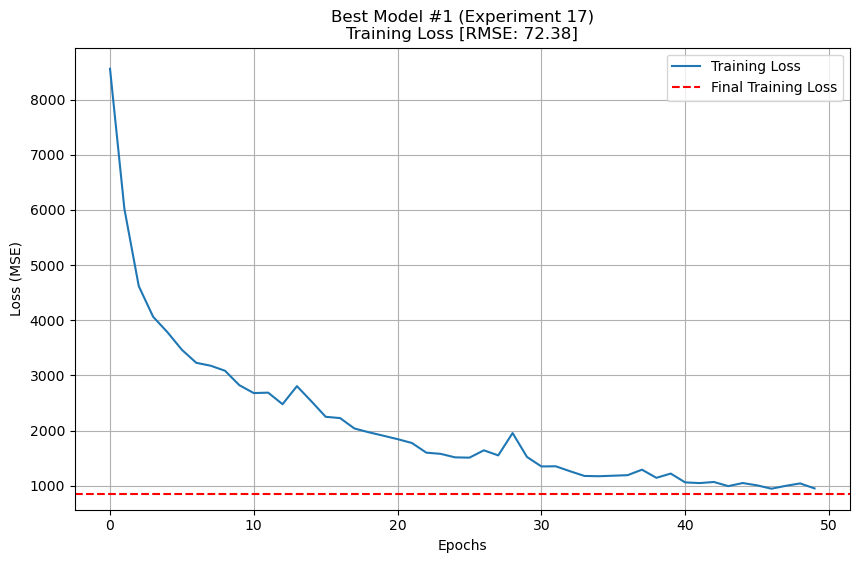

Experiment 17:
    - Final Training Loss: 846.64
    - Validation RMSE: 72.38
    - Plot saved to submissions/best_model_1_loss_plot.png

766/766 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step
Train Loss: 846.6376496889275


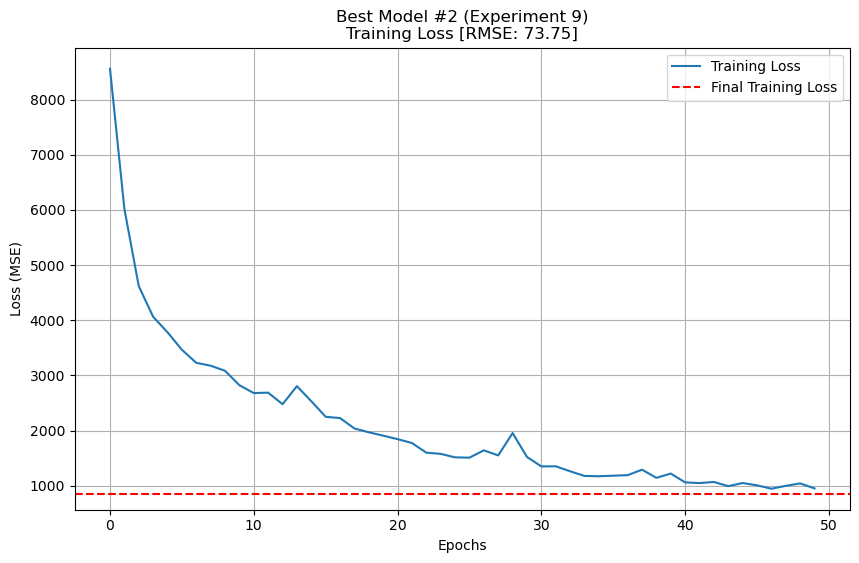

Experiment 9:
    - Final Training Loss: 846.64
    - Validation RMSE: 73.75
    - Plot saved to submissions/best_model_2_loss_plot.png



In [29]:
# Plot training loss for top 2 models
print("\nGenerating Training Loss Plots for Best Models...")

for i, (rmse, exp_id, path) in enumerate(best_submissions[:2], 1):
    # Calculate final training loss
    train_predictions = model.predict(X_train_seq)
    train_loss = np.mean((y_train_seq - train_predictions.flatten())**2)

    # Print train_loss here
    print(f"Train Loss: {train_loss}")

    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.axhline(y=train_loss, color='r', linestyle='--', label='Final Training Loss')
    plt.title(f'Best Model #{i} (Experiment {exp_id})\nTraining Loss [RMSE: {rmse:.2f}]')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    
    # Save plot
    plot_path = f'submissions/best_model_{i}_loss_plot.png'
    plt.savefig(plot_path)
    plt.show()
    
    print(f'''Experiment {exp_id}:
    - Final Training Loss: {train_loss:.2f}
    - Validation RMSE: {rmse:.2f}
    - Plot saved to {plot_path}\n''')